
<table>
  <tr><td>
    <img src="https://raw.githubusercontent.com/pyresearch/pyresearch/main/pyresearch.jpeg"
         alt="Fashion MNIST sprite"  width="1000">
  </td></tr>
  <tr><td align="center">
    <b>Classifying disease using Deep Learning
  </td></tr>
</table>


# UNDERSTAND THE PROBLEM STATEMENT AND BUSINESS CASE

Objective: The main objective is to develop an automated system that can accurately classify lung diseases based on medical images, such as X-rays or CT scans.

Scope: The scope includes identifying and classifying different types of lung diseases, which may include but are not limited to pneumonia, tuberculosis, lung cancer, and other respiratory conditions.

# IMPORT LIBRARIES AND DATASET

In [32]:
# This is a custom dataset that contains covid-19 x-ray images, viral pneumonia x-ray images, bacterial pneumonia x-ray iamges and normal person x-ray images.
# Each class contains 133 images.
# Dataset Source:
# https://github.com/ieee8023/covid-chestxray-dataset
# https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [33]:
# Specify training data directory
X_Ray_Directory = 'Operations/Dataset'

In [34]:
# List the folders in the directory
os.listdir(X_Ray_Directory)

['.DS_Store', '0', '1', '3', '2']

In [35]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation
image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [36]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, directory = X_Ray_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'training')

Found 428 images belonging to 4 classes.


In [37]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory = X_Ray_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'validation')

Found 104 images belonging to 4 classes.


In [38]:
# Generate a batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [39]:
train_images.shape

(40, 256, 256, 3)

In [40]:
train_labels.shape

(40, 4)

In [41]:
train_labels

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]],

In [42]:
# labels Translator
label_names = { 0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

# VISUALIZE DATASET

Background: Lung diseases are a major global health concern, and their early and accurate diagnosis is crucial for effective treatment. Deep learning can assist in automating this process, thereby improving diagnostic accuracy, reducing human error, and saving time.



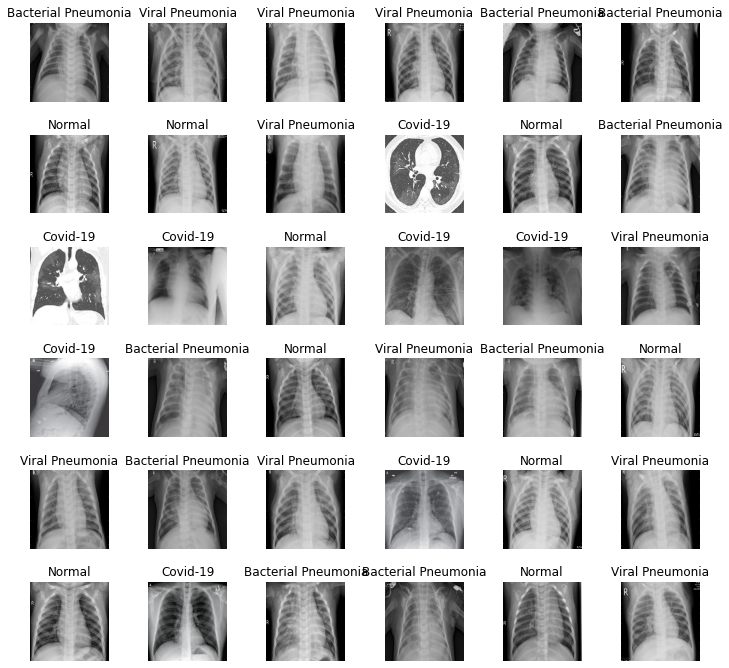

In [43]:
L = 6
W = 6

fig , axes = plt.subplots(L,W,figsize = (12,12))
axes = axes.ravel() #ravel used to flatten the axis

for i in np.arange(0, L * W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)

# IMPORT MODEL WITH PRETRAINED WEIGHTS

In [44]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256,256,3)))

In [45]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 8, 8, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 8, 8, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [46]:
# freezing layers in the model
for layer in basemodel.layers[:-10]:
  layers.trainable = False

# BUILD AND TRAIN DEEP LEARNING MODEL

In [47]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)


In [48]:
model = Model(inputs = basemodel.input,outputs = headmodel)

In [49]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

In [50]:
# using early stopping to exit training if validation loss is not decreasing after certain number of epochs (patience)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', save_best_only=True)

In [51]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'training')
val_generator = image_generator.flow_from_directory(batch_size = 4, directory = X_Ray_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [52]:
history = model.fit_generator(train_generator, epochs = 5, validation_data = val_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/5


/var/folders/1x/cgyx79bn3312d18nfb7bh2th0000gn/T/ipykernel_12121/3967208039.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs = 5, validation_data = val_generator, callbacks = [checkpointer, earlystopping])
2023-11-08 00:13:48.273867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


107/107 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 0.6472

2023-11-08 00:17:17.821820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


107/107 [==============================] - 220s 2s/step - loss: 0.9206 - accuracy: 0.6472 - val_loss: 2.7858 - val_accuracy: 0.2500
Epoch 2/5
107/107 [==============================] - 176s 2s/step - loss: 0.4828 - accuracy: 0.8318 - val_loss: 6.2647 - val_accuracy: 0.2500
Epoch 3/5
107/107 [==============================] - 171s 2s/step - loss: 0.3269 - accuracy: 0.8879 - val_loss: 9.9597 - val_accuracy: 0.2500
Epoch 4/5
107/107 [==============================] - 190s 2s/step - loss: 0.2622 - accuracy: 0.9276 - val_loss: 5.6819 - val_accuracy: 0.2500
Epoch 5/5
107/107 [==============================] - 205s 2s/step - loss: 0.1903 - accuracy: 0.9579 - val_loss: 14.3942 - val_accuracy: 0.2500


#  EVALUATE TRAINED DEEP LEARNING MODEL

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Training Accuracy and Loss')

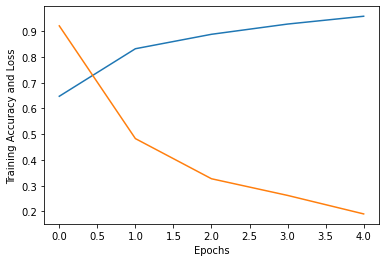

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy and Loss')

Text(0, 0.5, 'Validation Loss')

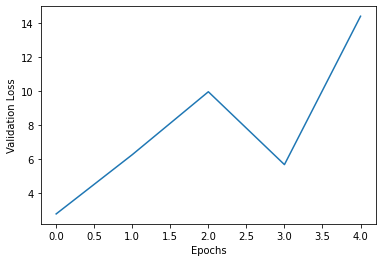

In [55]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Accuracy')

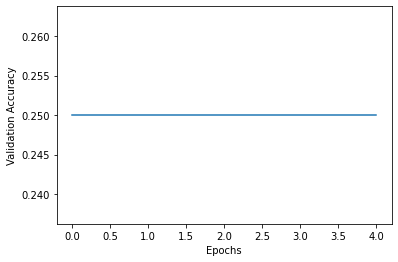

In [56]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

In [59]:
test_directory = 'Operations/Test'

In [60]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory, shuffle = True, target_size = (256,256), class_mode = 'categorical')
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//4, verbose = 1)
print('Accuracy Test: {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


/var/folders/1x/cgyx79bn3312d18nfb7bh2th0000gn/T/ipykernel_12121/2185729039.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n//4, verbose = 1)
2023-11-08 00:32:46.266779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 5s 5ms/step - loss: 14.5153 - accuracy: 0.2500
Accuracy Test: 0.25


In [61]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [63]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img = cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img/255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 166ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'Operations/Test/4'

In [64]:
score = accuracy_score(original, prediction)
print('Test Accuracy: {}'.format(score))

Test Accuracy: 0.25


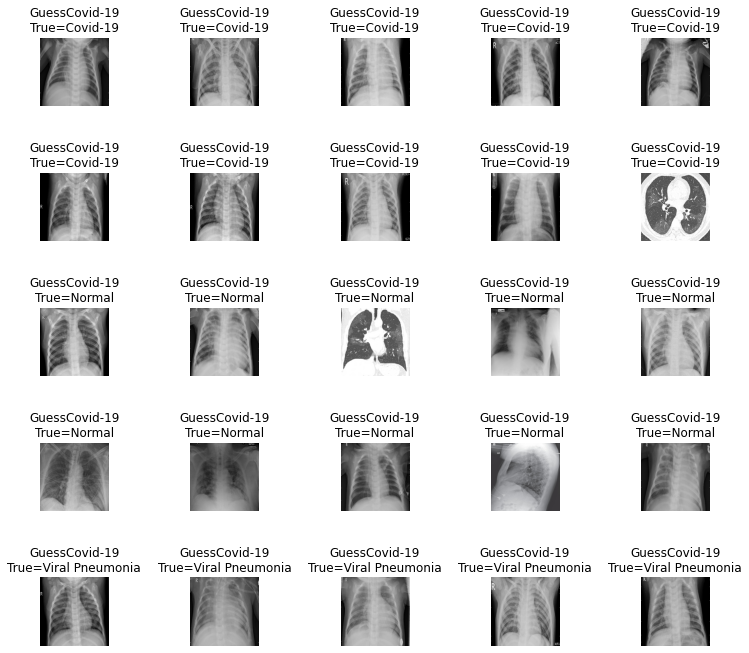

In [67]:
L = 5
W = 5

fig , axes = plt.subplots(L,W,figsize = (12,12))
axes = axes.ravel() #ravel used to flatten the axis

for i in np.arange(0, L * W):
  axes[i].imshow(train_images[i])
  axes[i].set_title('Guess{}\nTrue={}'.format(str(label_names[prediction[i]]),str(label_names[original[i]])))
  axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2)

In [66]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.00      0.00      0.00        10

    accuracy                           0.25        40
   macro avg       0.06      0.25      0.10        40
weighted avg       0.06      0.25      0.10        40



/Users/macbook/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion_matrix')

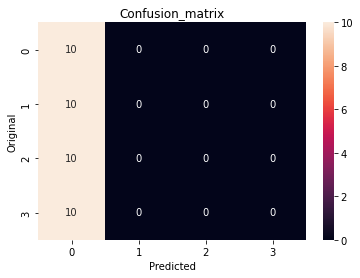

In [68]:
cm = confusion_matrix(np.array(original),np.array(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')